### Description of notebook

In this notebook, a balanced random forest (BRF) is trained on the publicly available [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains 284.807 credit card transactions, of which 492 were fraudulent. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Overview of the notebook:
1. Loading libraries
2. Loading and preparing dataset
3. Balanced Random Forest
4. Evaluating model predictions
5. Performing sensitivity testing

### 1. Loading libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
warnings.filterwarnings('ignore')

### 2. Loading and preparing dataset

In [2]:
# Load dataset
data = pd.read_csv('./data/creditcard.csv')

# Drop 'Time' feature as it's not useful for classification
data = data.drop(columns=['Time'])

# Separate features and target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
# dimensions
data.shape

(284807, 30)

In [4]:
# preview of data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# imbalancedness of dataset
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### 3. Balanced Random Forest
#### 3.1 Model initialization

In [6]:
# initialize the Balanced Random Forest classifier
clf = BalancedRandomForestClassifier(n_estimators=100, 
                                     max_depth=None,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     max_features=X.shape[1],
                                     random_state=42)



#### 3.2 Train and test model using 5-fold cross validation

In [7]:
# define the number of folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# store predictions and true labels
all_y_probs_ls = []
all_y_test_ls = []

# perform cross-validation 30:70 split
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # train the model
    clf.fit(X_train_fold, y_train_fold)
    
    # predict probabilities
    y_probs_fold = clf.predict_proba(X_test_fold)[:, 1]
    
    # collect true labels and predicted probabilities
    all_y_probs_ls.append(y_probs_fold.tolist())
    all_y_test_ls.append(y_test_fold.tolist())

### 4. Evaluating the model

In [8]:
# make lists equal length
all_y_probs_ls[4].append(all_y_probs_ls[4][39871])
all_y_test_ls[4].append(all_y_test_ls[4][39871])

#### Plot precision-recall curve for all folds

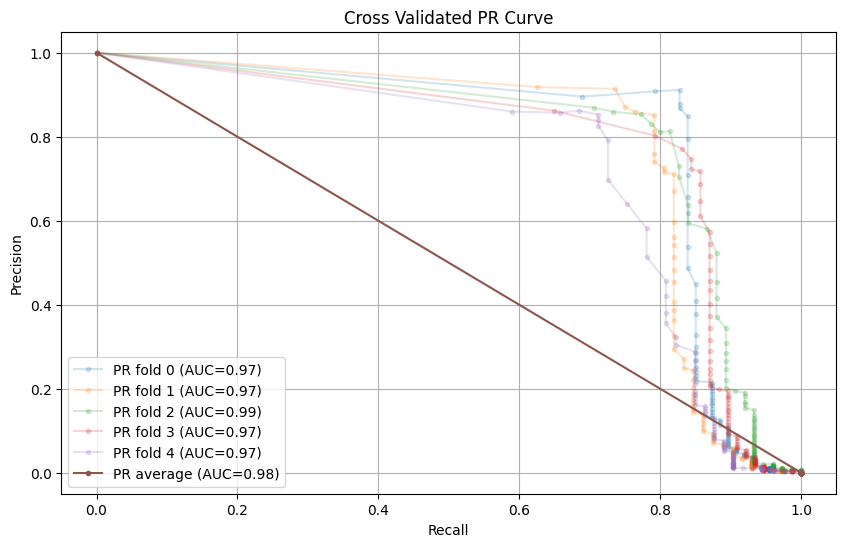

In [9]:
# initialize figure
plt.figure(figsize=(10, 6))

# initialize auc list
auc_ls = []

# plot each fold
for i in range(0,n_splits):

    # get data from list
    y_proba = all_y_probs_ls[i]
    y_test = all_y_test_ls[i]

    # compute precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # compute the AUC score
    auc = roc_auc_score(y_test, y_proba)
    auc_ls.append(auc)

    # Plot PR curve
    plt.plot(recall, precision, marker='.', label=f'PR fold {i} (AUC={auc:.2f})', alpha=0.2)

# average of all folds
avg_y_probs = np.array(all_y_probs_ls).mean(axis=0).tolist()
avg_y_test_mean = np.array(all_y_test_ls).mean(axis=0)
avg_y_test = np.where(avg_y_test_mean > 0.5, 1, 0)
auc_avg = np.array(auc_ls).mean()

# compute precision-recall pairs for different probability thresholds
precision_avg, recall_avg, thresholds = precision_recall_curve(avg_y_test, avg_y_probs)

# plot average of all folds
plt.plot(recall_avg, precision_avg, marker='.', label=f'PR average (AUC={auc_avg:.2f})')

# axis and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cross Validated PR Curve')

plt.legend()
plt.grid(True)
plt.show()

In [11]:
# # Plot point from confusion matrix
# plt.scatter(recall_from_cm, precision_from_cm, color='red', marker='x', label=f'Threshold = {thres}')

# # Predict classes based on the threshold of interest
# thres = 0.98
# y_pred = (y_proba >= thres).astype(int)

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Extract TP, FP, FN, TN from confusion matrix
# TN, FP, FN, TP = conf_matrix.ravel()

# # Calculate precision and recall based on confusion matrix
# precision_from_cm = TP / (TP + FP)
# recall_from_cm = TP / (TP + FN)
# TPR_from_cm = TP / (TP + FN)
# FPR_from_cm = FP / (FP + TN)

# print(f"Precision from Confusion Matrix for threshold {thres}: {precision_from_cm:.2f}")
# print(f"Recall from Confusion Matrix for threshold {thres}: {recall_from_cm:.2f}")

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for threshold {thres}:")
print(conf_matrix)

Confusion Matrix for threshold 0.98:
[[85293    14]
 [   29   107]]


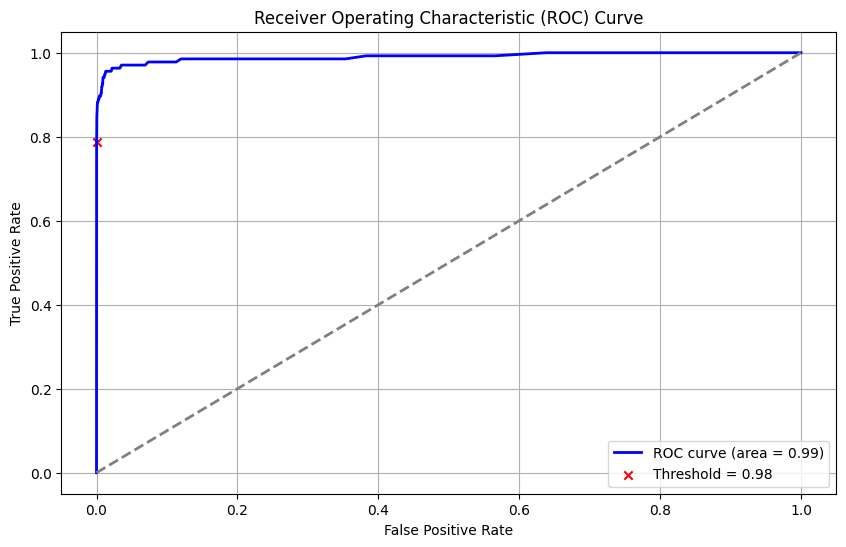

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Plot point from confusion matrix
plt.scatter(FPR_from_cm, TPR_from_cm, color='red', marker='x', label=f'Threshold = {thres}')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 5. Performing sensitivity testing

In [ ]:
# Find the optimal threshold to balance false positives and false negatives
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold: {optimal_threshold:.2f}")

# Predict with the new threshold
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Evaluate with the new threshold
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("Confusion Matrix with Adjusted Threshold:")
print(conf_matrix_adjusted)

# Classification report with the new threshold
class_report_adjusted = classification_report(y_test, y_pred_adjusted)
print("Classification Report with Adjusted Threshold:")
print(class_report_adjusted)

Threshold: 0.65
Confusion Matrix with Adjusted Threshold:
[[84190  1117]
 [    6   130]]
Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.10      0.96      0.19       136

    accuracy                           0.99     85443
   macro avg       0.55      0.97      0.59     85443
weighted avg       1.00      0.99      0.99     85443

